<a href="https://colab.research.google.com/github/elifsare/Real-time-Age-Gender-Ethnicity-Detection/blob/main/model0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 87% 55.0M/63.2M [00:00<00:00, 172MB/s]
100% 63.2M/63.2M [00:00<00:00, 148MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip '/content/age-gender-and-ethnicity-face-data-csv.zip' -d dataset

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: dataset/age_gender.csv  


In [6]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from keras.models import Sequential     
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('/content/dataset/age_gender.csv')

In [8]:
## Converting pixels into numpy array
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [9]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

data visulate

In [10]:
df1 = df.drop('img_name', axis=1)
y1 = df1.drop("pixels", axis=1)

In [11]:
y1.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


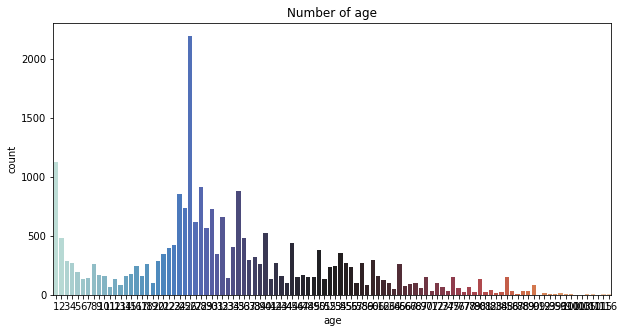

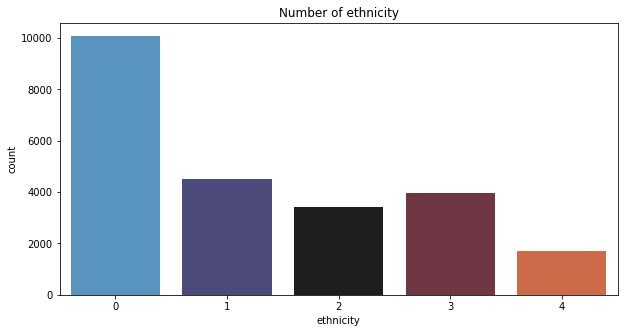

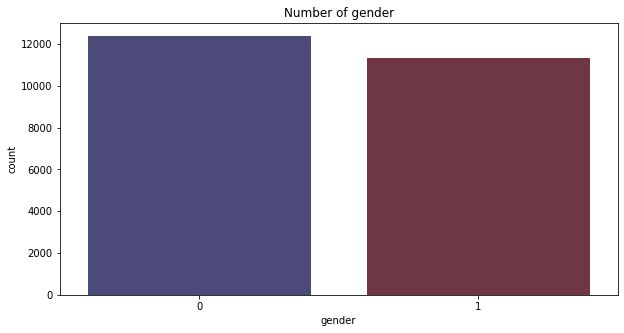

In [12]:
import seaborn as sns
for i in y1.columns:
    plt.figure(figsize=(10,5))
    g = sns.countplot(y1[i], palette="icefire")
    plt.title("Number of {}".format(i))

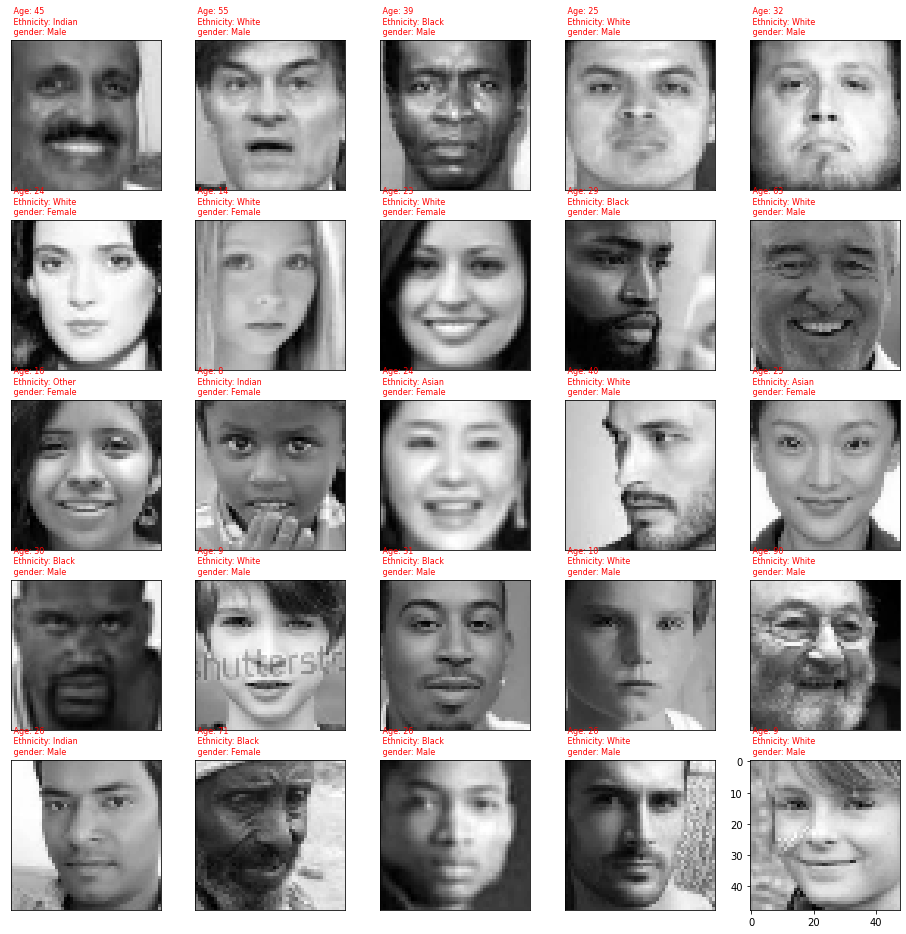

In [13]:
plt.figure(figsize=(16, 16))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

Age Model

In [14]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))
y = df['age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=30)

image generetor

In [15]:
train_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2
                                    )
validation_generator = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [16]:
train_flow_age = train_generator.flow(X_test_age,
                                  y_test_age,
                                  batch_size=32)

validation_flow_age = validation_generator.flow(X_test_age,
                                            y_test_age,
                                            batch_size=32)

Checkpoint

In [17]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model.h5', verbose = 1, save_best_only = True)

overfitting engelliyoruz
EarlyStop

In [23]:
"""earlystop = EarlyStopping(patience = 6)

learning_rate_reduction = ReduceLROnPlateau( monitor='val_acc',
                                             patience= 3,
                                             verbose=1)

callbacks = [earlystop, checkPointer, learning_rate_reduction]"""


early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [22]:
model_age = Sequential()

model_age.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2)) 

model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2)) 

model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))

model_age.add(Conv2D(128,(3,3),activation='relu'))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))          
          
model_age.add(Flatten())
model_age.add(BatchNormalization())
model_age.add(Dropout(0.5))            

model_age.add(Dense(1,activation='relu'))

model_age.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

model_age.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 21, 21, 64)      

In [20]:
epochs = 60

In [25]:
h = model_age.fit(train_flow_age, 
              epochs= epochs,
              validation_split=0.1,
              validation_data= validation_flow_age,
              callbacks= callbacks_list)

Epoch 1/60
223/223 [==============================] - ETA: 0s - loss: 477.0956 - mae: 16.7731
Epoch 1: val_loss improved from 481.79266 to 332.41159, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model.h5
223/223 [==============================] - 9s 41ms/step - loss: 477.0956 - mae: 16.7731 - val_loss: 332.4116 - val_mae: 14.1117 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - ETA: 0s - loss: 327.4914 - mae: 13.8213
Epoch 2: val_loss did not improve from 332.41159
223/223 [==============================] - 5s 23ms/step - loss: 327.4914 - mae: 13.8213 - val_loss: 1389.5016 - val_mae: 31.5493 - lr: 0.0010
Epoch 3/60
223/223 [==============================] - ETA: 0s - loss: 349.7639 - mae: 14.2601
Epoch 3: val_loss improved from 332.41159 to 324.27011, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model.h5
223/223 [==============================] - 5s 22ms/step - loss: 349.7639 - mae: 14.2601 - val_

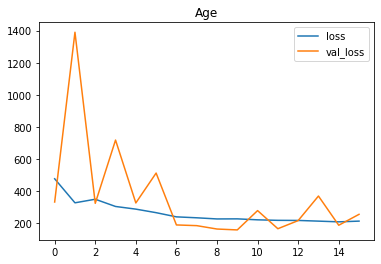

In [26]:
losses_age = pd.DataFrame(h.history)
losses_age[['loss','val_loss']].plot(title='Age')

In [31]:
train_loss, train_acc = model_age.evaluate(train_flow_age)
test_loss, test_acc   = model_age.evaluate(validation_flow_age)

223/223 [==============================] - 1s 6ms/step - loss: 158.7423 - mae: 9.3218
